In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [183]:
# URLs for the datasets
customers_url = 'https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv'
engagements_url = 'https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv'
marketing_url = 'https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv'
transactions_url = 'https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv'

# Reading the datasets
customers = pd.read_csv(customers_url)
engagements = pd.read_csv(engagements_url)
marketing = pd.read_csv(marketing_url)
transactions = pd.read_csv(transactions_url)

# Convert date columns to datetime type
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Mark missing values in 'age' as 'NA'
customers['age'].fillna('NA', inplace=True)

# Mark missing values in 'gender' as 'NA'
customers['gender'].fillna('NA', inplace=True)

print("\nAfter replacing missing values in 'gender' with 'NA':")
print(customers)

# Display the first few rows of each dataset
print("Customers Data:")
print(customers.head())

print("\nEngagements Data:")
print(engagements.head())

print("\nMarketing Data:")
print(marketing.head())

print("\nTransactions Data:")
print(transactions.head())



After replacing missing values in 'gender' with 'NA':
      customer_id  join_date last_purchase_date   age  gender  \
0               1 2023-11-20         2024-03-17  56.0  Female   
1               2 2021-09-08         2023-10-25    NA    Male   
2               3 2021-06-01         2022-11-27    NA      NA   
3               4 2022-01-01         2022-09-01  29.0    Male   
4               5 2022-01-24         2023-06-02    NA    Male   
...           ...        ...                ...   ...     ...   
9995         9996 2022-12-16         2023-08-13  42.0  Female   
9996         9997 2022-07-09         2023-01-25  26.0    Male   
9997         9998 2023-09-17         2024-01-30  39.0    Male   
9998         9999 2022-05-10         2022-07-15  31.0  Female   
9999        10000 2023-05-26         2023-09-01  67.0    Male   

               location  
0     North Shannonbury  
1             Hillville  
2      North Latoyatown  
3             Grossstad  
4      East Matthewfort  
...     

/var/folders/j6/k6gy0m_x02b05c849w1998_c0000gn/T/ipykernel_14022/4031691346.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['age'].fillna('NA', inplace=True)
/var/folders/j6/k6gy0m_x02b05c849w1998_c0000gn/T/ipykernel_14022/4031691346.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  customers['age'].fillna('NA', inplace=True)
/var/fol

In [184]:
# Check for missing values
print("Missing values in customers data:\n", customers.isnull().sum())
print("Missing values in engagements data:\n", engagements.isnull().sum())
print("Missing values in marketing data:\n", marketing.isnull().sum())
print("Missing values in transactions data:\n", transactions.isnull().sum())

Missing values in customers data:
 customer_id           0
join_date             0
last_purchase_date    0
age                   0
gender                0
location              0
dtype: int64
Missing values in engagements data:
 customer_id                0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
dtype: int64
Missing values in marketing data:
 campaign_id       0
customer_id       0
response          0
promotion_type    0
campaign_date     0
dtype: int64
Missing values in transactions data:
 transaction_id        0
customer_id           0
transaction_date      0
transaction_amount    0
product_category      0
dtype: int64


In [185]:
# Feature Engineering
customer_spending = transactions.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_spending.columns = ['customer_id', 'total_spending']

customer_transactions = transactions.groupby('customer_id')['transaction_id'].count().reset_index()
customer_transactions.columns = ['customer_id', 'total_transactions']

customer_last_purchase = transactions.groupby('customer_id')['transaction_date'].max().reset_index()
customer_last_purchase.columns = ['customer_id', 'last_transaction_date']

customer_first_purchase = transactions.groupby('customer_id')['transaction_date'].min().reset_index()
customer_first_purchase.columns = ['customer_id', 'first_transaction_date']

customers = customers.merge(customer_spending, on='customer_id', how='left')
customers = customers.merge(customer_transactions, on='customer_id', how='left')
customers = customers.merge(customer_last_purchase, on='customer_id', how='left')
customers = customers.merge(customer_first_purchase, on='customer_id', how='left')

# Display the updated customers dataframe
print("Updated Customers Data after Feature Engineering:")
print(customers.head())




Updated Customers Data after Feature Engineering:
   customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  
0             2024-01-09  
1             2021-09-29  
2  

In [186]:
customers.head()

customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  
0             2024-01-09  
1             2021-09-29  
2             2021-09-28  
3             2022-01-11  
4             2022-03-02

In [187]:
# Merge engagements data into customers_df
customers = customers.merge(engagements, on='customer_id', how='left')

# Display the updated customers dataframe
print("Updated Customers Data after merging engagements:")
print(customers.head())


Updated Customers Data after merging engagements:
   customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  number_of_site_visits  number_of_emails_opened  \
0       

In [188]:
customers.head()

customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  number_of_site_visits  number_of_emails_opened  \
0             2024-01-09                     10                       15   
1             2021-09-29                    285                       49   
2             2021-09-28                    192                       73   
3             2022-01-11                    110                       30   
4             2022-03-02                    161                        2   

   number_of_clicks  
0                 1  
1                51  
2                25  
3                17  
4                 7

In [189]:
# Perform one-hot encoding on the promotion_type column
promotion_one_hot = pd.get_dummies(marketing['promotion_type'], prefix='promo')
marketing = pd.concat([marketing, promotion_one_hot], axis=1)

# Check the columns after one-hot encoding
print("Columns after one-hot encoding:", marketing.columns)

# Aggregate the number of each promotion type received by each customer
promotion_summary = marketing.groupby('customer_id').agg({
    'promo_Discount': 'sum',
    'promo_Buy One Get One': 'sum',
    'promo_Free Shipping': 'sum',
    'response': lambda x: (x == 'Yes').sum()
}).reset_index()

promotion_summary.columns = ['customer_id', 'promo_Discount', 'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']

# Display the promotion summary dataframe
print("Promotion Summary Data:")
print(promotion_summary.head())



Columns after one-hot encoding: Index(['campaign_id', 'customer_id', 'response', 'promotion_type',
       'campaign_date', 'promo_Buy One Get One', 'promo_Discount',
       'promo_Free Shipping'],
      dtype='object')


Promotion Summary Data:
   customer_id  promo_Discount  promo_BuyOneGetOne  promo_FreeShipping  \
0            1               1                   2                   1   
1            2               1                   0                   3   
2            3               0                   2                   0   
3            4               1                   1                   2   
4            5               2                   1                   1   

   total_responses  
0                1  
1                2  
2                1  
3                1  
4                0  


In [190]:
customers.head()

customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  number_of_site_visits  number_of_emails_opened  \
0             2024-01-09                     10                       15   
1             2021-09-29                    285                       49   
2             2021-09-28                    192                       73   
3             2022-01-11                    110                       30   
4             2022-03-02                    161                        2   

   number_of_clicks  
0                 1  
1                51  
2                25  
3                17  
4                 7

In [191]:
# Merge promotion summary into customers_df
customers = customers.merge(promotion_summary, on='customer_id', how='left')

# Calculate average purchase value
customers['avg_purchase_value'] = customers['total_spending'] / customers['total_transactions']

# Calculate customer lifespan (in days)
customers['customer_lifespan'] = (customers['last_transaction_date'] - customers['first_transaction_date']).dt.days

# Set all lifespan values less than 1 to 30
customers['customer_lifespan'] = customers['customer_lifespan'].apply(lambda x: 1 if x < 1 else x)

# Calculate CLV(by month)
customers['CLV'] = customers['total_spending'] / customers['customer_lifespan'] * 30

# Display the updated customers dataframe with CLV
print("Customers Data with CLV:")
print(customers[['customer_id', 'avg_purchase_value',  'customer_lifespan', 'CLV']].head())


Customers Data with CLV:
   customer_id  avg_purchase_value  customer_lifespan          CLV
0            1          584.913333                 63  1671.180952
1            2          675.702222                515   354.251650
2            3          242.478333                416   104.918510
3            4          393.734000                232  1018.277586
4            5          646.856250                456  1021.351974


In [192]:
customers.head()

customer_id  join_date last_purchase_date   age  gender           location  \
0            1 2023-11-20         2024-03-17  56.0  Female  North Shannonbury   
1            2 2021-09-08         2023-10-25    NA    Male          Hillville   
2            3 2021-06-01         2022-11-27    NA      NA   North Latoyatown   
3            4 2022-01-01         2022-09-01  29.0    Male          Grossstad   
4            5 2022-01-24         2023-06-02    NA    Male   East Matthewfort   

   total_spending  total_transactions last_transaction_date  \
0         3509.48                   6            2024-03-12   
1         6081.32                   9            2023-02-26   
2         1454.87                   6            2022-11-18   
3         7874.68                  20            2022-08-31   
4        15524.55                  24            2023-06-01   

  first_transaction_date  number_of_site_visits  number_of_emails_opened  \
0             2024-01-09                     10                       15   
1             2021-09-29                    285                       49   
2             2021-09-28                    192                       73   
3             2022-01-11                    110                       30   
4             2022-03-02                    161                        2   

   number_of_clicks  promo_Discount  promo_BuyOneGetOne  promo_FreeShipping  \
0                 1               1                   2                   1   
1                51               1                   0                   3   
2                25               0                   2                   0   
3                17               1                   1                   2   
4                 7               2                   1                   1   

   total_responses  avg_purchase_value  customer_lifespan          CLV  
0                1          584.913333                 63  1671.180952  
1                2          675.702222                515   354.251650  
2                1          242.478333                416   104.918510  
3                1          393.734000                232  1018.277586  
4                0          646.856250                456  1021.351974

In [193]:
customers.describe()

customer_id                      join_date          last_purchase_date  \
count  10000.00000                          10000                       10000   
mean    5000.50000  2022-03-19 09:28:13.439999744  2023-04-25 18:26:12.480000   
min        1.00000            2020-01-01 00:00:00         2020-01-26 00:00:00   
25%     2500.75000            2021-02-15 00:00:00         2022-09-19 00:00:00   
50%     5000.50000            2022-03-19 00:00:00         2023-08-04 00:00:00   
75%     7500.25000            2023-04-28 00:00:00         2024-02-11 00:00:00   
max    10000.00000            2024-05-31 00:00:00         2024-05-31 00:00:00   
std     2886.89568                            NaN                         NaN   

       total_spending  total_transactions          last_transaction_date  \
count    10000.000000        10000.000000                          10000   
mean      7737.562981           12.954500  2023-03-08 17:50:29.759999744   
min         23.810000            1.000000            2020-01-26 00:00:00   
25%       3839.915000            7.000000            2022-07-17 00:00:00   
50%       7498.890000           13.000000            2023-06-05 00:00:00   
75%      11275.797500           19.000000            2023-12-31 06:00:00   
max      24298.220000           25.000000            2024-05-31 00:00:00   
std       4628.799469            7.191203                            NaN   

           first_transaction_date  number_of_site_visits  \
count                       10000           10000.000000   
mean   2022-05-04 06:41:02.400000             100.111900   
min           2020-01-06 00:00:00               1.000000   
25%           2021-04-24 00:00:00              15.000000   
50%           2022-05-17 00:00:00              53.000000   
75%           2023-05-27 00:00:00             141.000000   
max           2024-05-31 00:00:00             711.000000   
std                           NaN             118.625052   

       number_of_emails_opened  number_of_clicks  promo_Discount  \
count             10000.000000      10000.000000    10000.000000   
mean                 39.862100         19.725300        0.843000   
min                   1.000000          1.000000        0.000000   
25%                   6.000000          3.000000        0.000000   
50%                  22.000000         11.000000        1.000000   
75%                  57.000000         28.000000        1.000000   
max                 303.000000        142.000000        4.000000   
std                  46.511719         22.975083        0.834278   

       promo_BuyOneGetOne  promo_FreeShipping  total_responses  \
count        10000.000000          10000.0000     10000.000000   
mean             0.842200              0.8348         1.257800   
min              0.000000              0.0000         0.000000   
25%              0.000000              0.0000         1.000000   
50%              1.000000              1.0000         1.000000   
75%              1.000000              1.0000         2.000000   
max              4.000000              4.0000         4.000000   
std              0.843665              0.8382         0.971511   

       avg_purchase_value  customer_lifespan            CLV  
count        10000.000000       10000.000000   10000.000000  
mean           599.842451         308.514400    7577.119305  
min             23.810000           1.000000       9.626546  
25%            488.343409          64.000000     429.799905  
50%            587.587333         211.000000     971.805395  
75%            692.701750         472.000000    3108.901820  
max           1997.080000        1513.000000  596288.400000  
std            197.350557         303.013722   33329.124635

In [194]:
print("Columns in customers dataframe:")
print(customers.columns)


Columns in customers dataframe:
Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'total_spending', 'total_transactions',
       'last_transaction_date', 'first_transaction_date',
       'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
       'promo_Discount', 'promo_BuyOneGetOne', 'promo_FreeShipping',
       'total_responses', 'avg_purchase_value', 'customer_lifespan', 'CLV'],
      dtype='object')


In [195]:
# Use KNNImputer to fill missing 'age' values
features_for_age_prediction = customers[['total_spending', 'total_transactions', 'number_of_site_visits', 
                                         'number_of_emails_opened', 'number_of_clicks', 'promo_Discount', 
                                         'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']]

# Add 'age' column to the features
features_for_age_prediction['age'] = customers['age'].replace('NA', np.nan).astype(float)

# Use KNNImputer to fill missing 'age' values
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(features_for_age_prediction)

# Update the 'age' values in the customers DataFrame
customers['age'] = imputed_data[:, -1]

# Display the updated customers DataFrame with imputed 'age'
print("Customers Data with Imputed Age:")
print(customers[['customer_id', 'age']].head())


/var/folders/j6/k6gy0m_x02b05c849w1998_c0000gn/T/ipykernel_14022/499239633.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_for_age_prediction['age'] = customers['age'].replace('NA', np.nan).astype(float)
/var/folders/j6/k6gy0m_x02b05c849w1998_c0000gn/T/ipykernel_14022/499239633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_for_age_prediction['age'] = customers['age'].replace('NA', np.nan).astype(float)


Customers Data with Imputed Age:
   customer_id   age
0            1  56.0
1            2  46.2
2            3  52.2
3            4  29.0
4            5  43.6


In [196]:
# Ensure 'NA' in 'gender' column is correctly replaced with missing value indicator
customers['gender'] = customers['gender'].replace('NA', np.nan)

# Check the number of missing values in the 'gender' column
print("Missing values in 'gender' column:", customers['gender'].isna().sum())



Missing values in 'gender' column: 533


In [197]:
# Separate rows with known and unknown gender
known_gender = customers[customers['gender'].notna()]
unknown_gender = customers[customers['gender'].isna()]

# Confirm the number of samples with unknown gender
print("Number of known gender samples:", known_gender.shape[0])
print("Number of unknown gender samples:", unknown_gender.shape[0])



Number of known gender samples: 9467
Number of unknown gender samples: 533


In [198]:
# Select features for gender prediction
features_for_gender_prediction = customers[['age', 'total_spending', 'total_transactions', 'number_of_site_visits', 
                                            'number_of_emails_opened', 'number_of_clicks', 'promo_Discount', 
                                            'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']]

# Features and target for known gender samples
X_known_gender = known_gender[features_for_gender_prediction.columns]
y_known_gender = known_gender['gender']

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_known_gender, y_known_gender, test_size=0.3, random_state=42)

# Train a Random Forest model for gender prediction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
print(f"Gender prediction accuracy: {accuracy_score(y_test, y_pred)}")

# Predict for unknown gender data if it exists
if not unknown_gender.empty:
    # Predict the unknown gender data
    X_unknown_gender = unknown_gender[features_for_gender_prediction.columns]
    predicted_gender = rf_model.predict(X_unknown_gender)

    # Update the 'gender' column in the customers DataFrame
    customers.loc[customers['gender'].isna(), 'gender'] = predicted_gender

# Display the updated customers DataFrame with predicted 'gender'
print("Customers Data with Predicted Gender:")
print(customers[['customer_id', 'gender']].head())



Gender prediction accuracy: 0.5001759943681802
Customers Data with Predicted Gender:
   customer_id  gender
0            1  Female
1            2    Male
2            3  Female
3            4    Male
4            5    Male


In [199]:
print("Columns in customers dataframe:")
print(customers.columns)

Columns in customers dataframe:
Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'total_spending', 'total_transactions',
       'last_transaction_date', 'first_transaction_date',
       'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
       'promo_Discount', 'promo_BuyOneGetOne', 'promo_FreeShipping',
       'total_responses', 'avg_purchase_value', 'customer_lifespan', 'CLV'],
      dtype='object')


In [200]:
customers.describe()

customer_id                      join_date          last_purchase_date  \
count  10000.00000                          10000                       10000   
mean    5000.50000  2022-03-19 09:28:13.439999744  2023-04-25 18:26:12.480000   
min        1.00000            2020-01-01 00:00:00         2020-01-26 00:00:00   
25%     2500.75000            2021-02-15 00:00:00         2022-09-19 00:00:00   
50%     5000.50000            2022-03-19 00:00:00         2023-08-04 00:00:00   
75%     7500.25000            2023-04-28 00:00:00         2024-02-11 00:00:00   
max    10000.00000            2024-05-31 00:00:00         2024-05-31 00:00:00   
std     2886.89568                            NaN                         NaN   

                age  total_spending  total_transactions  \
count  10000.000000    10000.000000        10000.000000   
mean      43.393060     7737.562981           12.954500   
min       18.000000       23.810000            1.000000   
25%       31.200000     3839.915000            7.000000   
50%       43.000000     7498.890000           13.000000   
75%       55.000000    11275.797500           19.000000   
max       69.000000    24298.220000           25.000000   
std       14.467656     4628.799469            7.191203   

               last_transaction_date      first_transaction_date  \
count                          10000                       10000   
mean   2023-03-08 17:50:29.759999744  2022-05-04 06:41:02.400000   
min              2020-01-26 00:00:00         2020-01-06 00:00:00   
25%              2022-07-17 00:00:00         2021-04-24 00:00:00   
50%              2023-06-05 00:00:00         2022-05-17 00:00:00   
75%              2023-12-31 06:00:00         2023-05-27 00:00:00   
max              2024-05-31 00:00:00         2024-05-31 00:00:00   
std                              NaN                         NaN   

       number_of_site_visits  number_of_emails_opened  number_of_clicks  \
count           10000.000000             10000.000000      10000.000000   
mean              100.111900                39.862100         19.725300   
min                 1.000000                 1.000000          1.000000   
25%                15.000000                 6.000000          3.000000   
50%                53.000000                22.000000         11.000000   
75%               141.000000                57.000000         28.000000   
max               711.000000               303.000000        142.000000   
std               118.625052                46.511719         22.975083   

       promo_Discount  promo_BuyOneGetOne  promo_FreeShipping  \
count    10000.000000        10000.000000          10000.0000   
mean         0.843000            0.842200              0.8348   
min          0.000000            0.000000              0.0000   
25%          0.000000            0.000000              0.0000   
50%          1.000000            1.000000              1.0000   
75%          1.000000            1.000000              1.0000   
max          4.000000            4.000000              4.0000   
std          0.834278            0.843665              0.8382   

       total_responses  avg_purchase_value  customer_lifespan            CLV  
count     10000.000000        10000.000000       10000.000000   10000.000000  
mean          1.257800          599.842451         308.514400    7577.119305  
min           0.000000           23.810000           1.000000       9.626546  
25%           1.000000          488.343409          64.000000     429.799905  
50%           1.000000          587.587333         211.000000     971.805395  
75%           2.000000          692.701750         472.000000    3108.901820  
max           4.000000         1997.080000        1513.000000  596288.400000  
std           0.971511          197.350557         303.013722   33329.124635

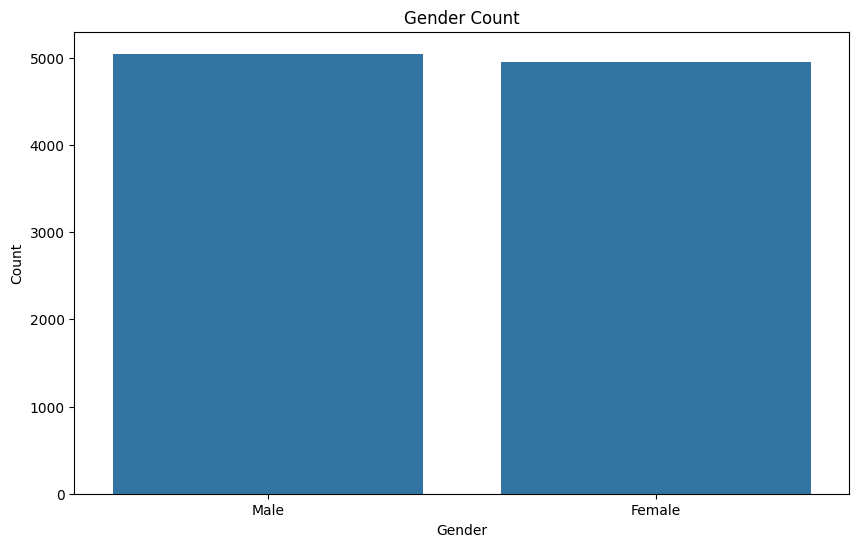

In [201]:
# View the count of the gender column
gender_counts = customers['gender'].value_counts()

# Plot a bar chart of the gender count
plt.figure(figsize=(10, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title('Gender Count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


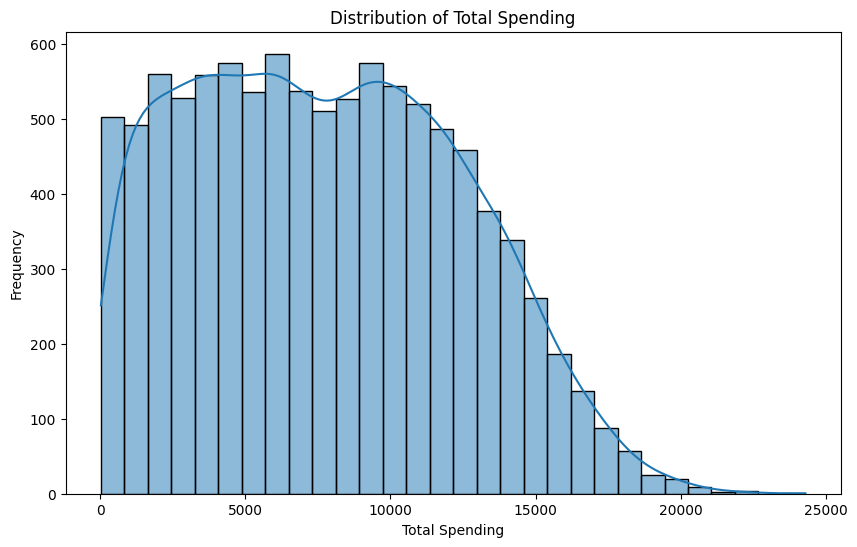

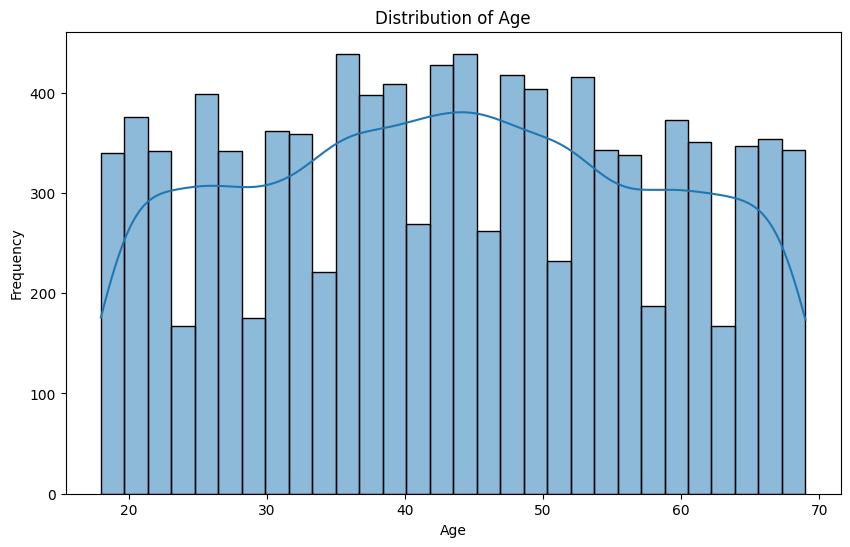

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of total_spending
plt.figure(figsize=(10, 6))
sns.histplot(customers['total_spending'], bins=30, kde=True)
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(customers['age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()




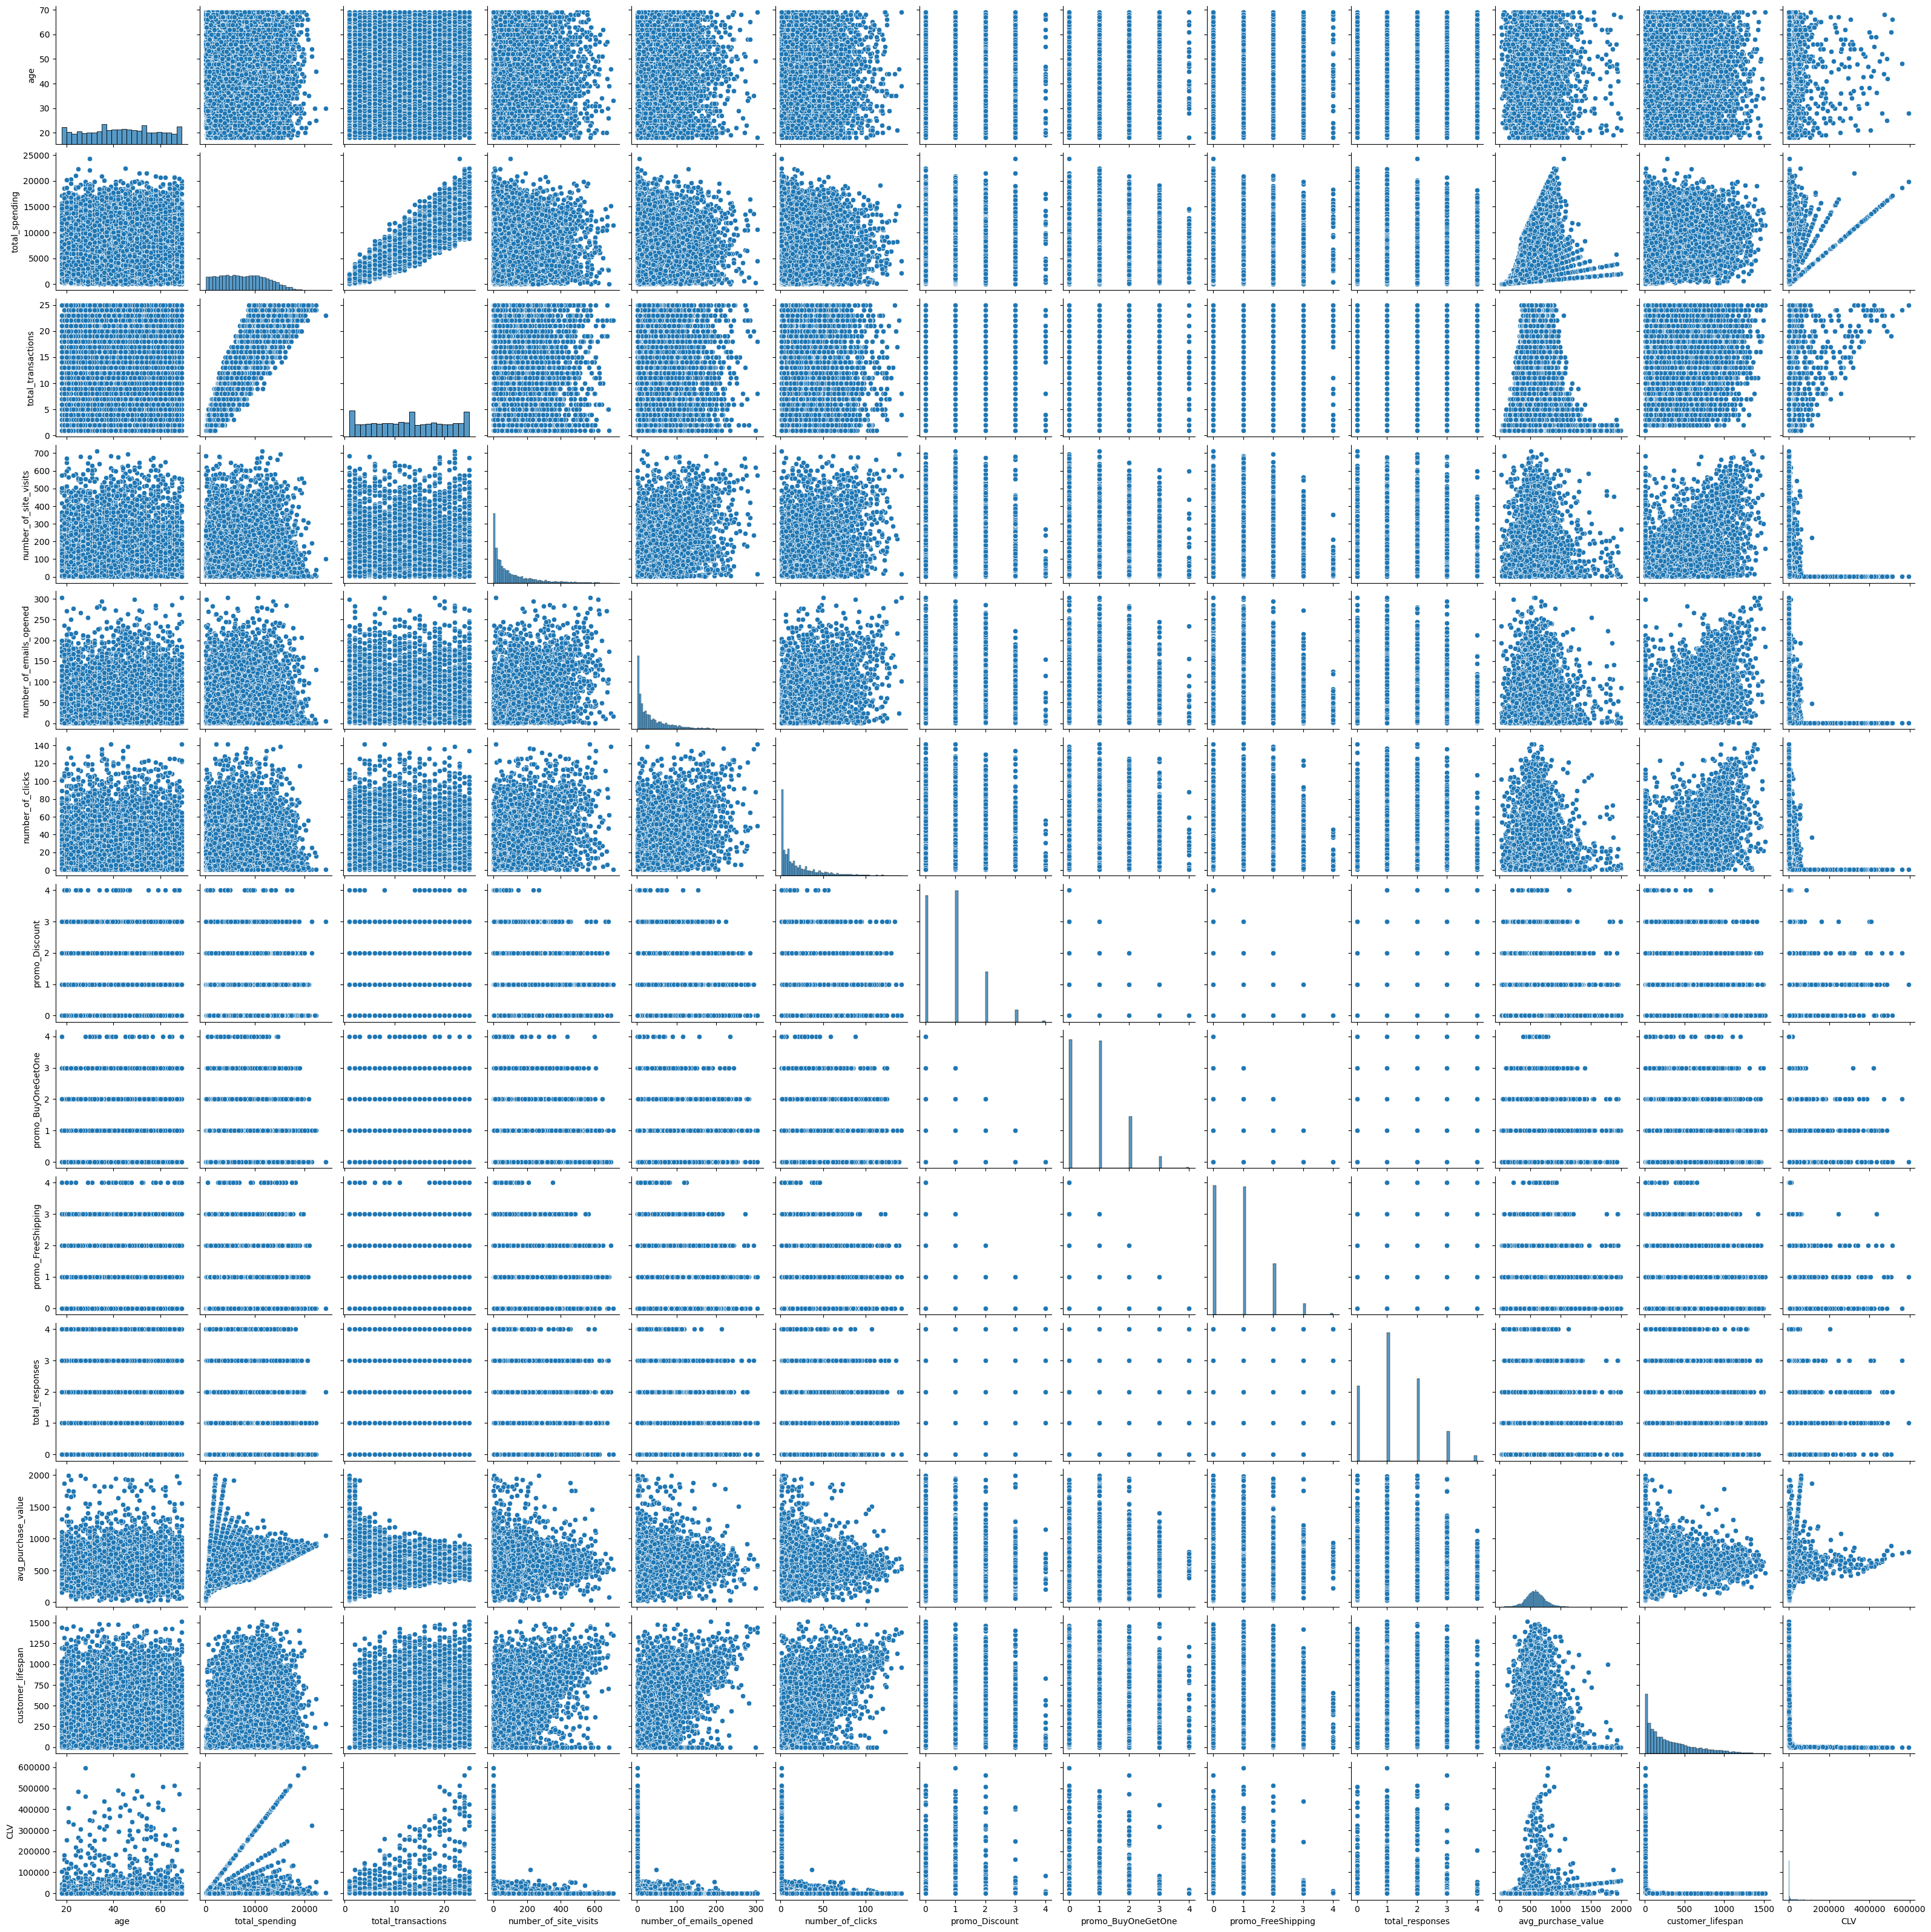

In [203]:
# Numerical feature columns
num_cols = ['age', 'total_spending', 'total_transactions', 'number_of_site_visits', 
            'number_of_emails_opened', 'number_of_clicks', 'promo_Discount', 
            'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses', 
            'avg_purchase_value', 'customer_lifespan', 'CLV']

# Plot relationships between numerical features
sns.pairplot(customers[num_cols])
plt.show()




In [204]:
# Calculate the 75th percentile of CLV
clv_75_quantile = customers['CLV'].quantile(0.75)
print(f"75th Percentile CLV: {clv_75_quantile}")

# Label high-value and low-value customers based on the 75th percentile
customers['customer_value'] = customers['CLV'].apply(lambda x: 'high-value' if x > clv_75_quantile else 'low-value')

# Display the updated DataFrame with customer value labels
print("Customers Data with Customer Value:")
print(customers[['customer_id', 'CLV', 'customer_value']].head())

# Convert the target variable to binary (high-value customer = 1, low-value customer = 0)
customers['customer_value_binary'] = customers['customer_value'].apply(lambda x: 1 if x == 'high-value' else 0)




75th Percentile CLV: 3108.9018200202227
Customers Data with Customer Value:
   customer_id          CLV customer_value
0            1  1671.180952      low-value
1            2   354.251650      low-value
2            3   104.918510      low-value
3            4  1018.277586      low-value
4            5  1021.351974      low-value


                         customer_value_binary       age  total_spending  \
customer_value_binary                 1.000000  0.000999        0.049750   
age                                   0.000999  1.000000        0.013781   
total_spending                        0.049750  0.013781        1.000000   
total_transactions                    0.019551  0.012066        0.922660   
number_of_site_visits                -0.350452 -0.020363       -0.008428   
number_of_emails_opened              -0.361938 -0.002425       -0.005792   
number_of_clicks                     -0.361341 -0.003400       -0.012685   
promo_Discount                       -0.000138 -0.020004        0.011646   
promo_BuyOneGetOne                    0.005886 -0.006428       -0.010180   
promo_FreeShipping                   -0.010470  0.003813        0.004948   
total_responses                       0.003922 -0.003544       -0.003452   
avg_purchase_value                    0.095478 -0.009407        0.250592   
customer_lif

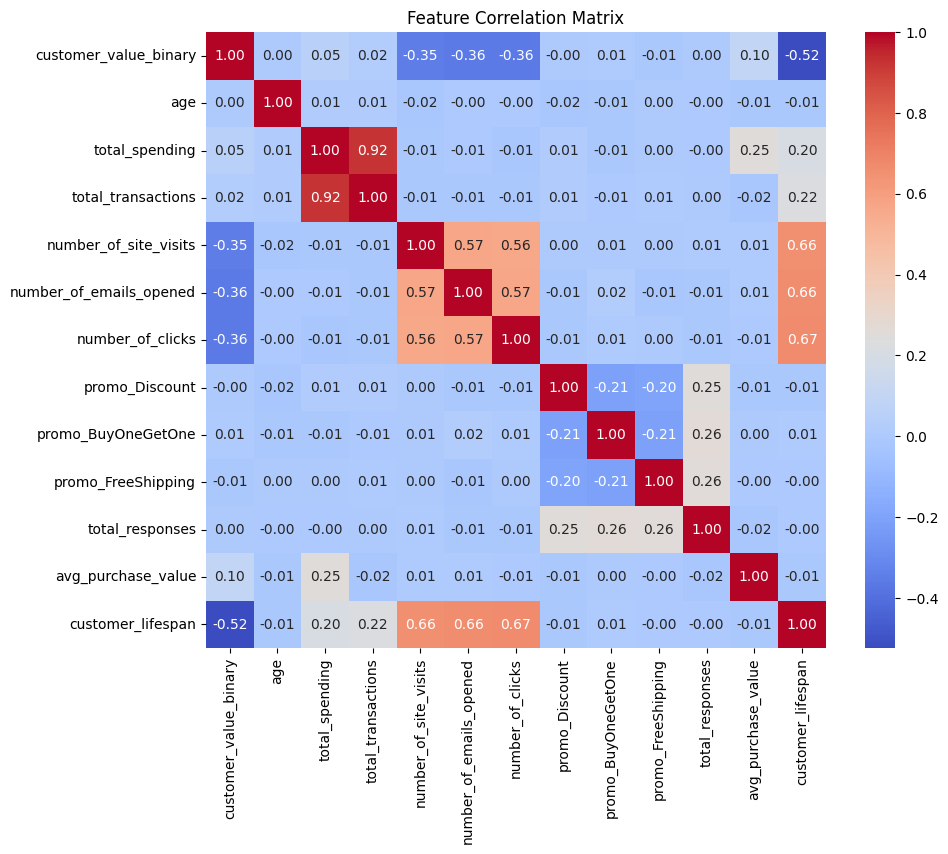

In [205]:
# Define features and target variable
features = ['customer_value_binary', 'age', 'total_spending', 'total_transactions', 'number_of_site_visits',
            'number_of_emails_opened', 'number_of_clicks', 'promo_Discount',
            'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses',
            'avg_purchase_value', 'customer_lifespan']

# Calculate the correlation matrix
correlation_matrix = customers[features].corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


In [206]:
# Define features and target variable
features = ['age', 'gender', 'location', 'number_of_site_visits', 'number_of_emails_opened',
            'number_of_clicks', 'promo_Discount', 
            'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']
target = 'customer_value'


In [207]:
# demonstrate OHE
OneHotEncoder().fit_transform(customers[['gender', 'location']])

<10000x7697 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements in Compressed Sparse Row format>

In [208]:
# Define numeric and categorical columns
numeric_columns = ['age', 'number_of_site_visits', 'number_of_emails_opened',
                   'number_of_clicks', 'promo_Discount', 
                   'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']
categorical_columns = ['gender', 'location']

# Create a preprocessing pipeline, including scaling for numeric variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        # Add categorical variables if needed
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)



In [209]:
# Split the dataset
X = customers[['age', 'gender', 'location', 'number_of_site_visits', 'number_of_emails_opened',
               'number_of_clicks', 'promo_Discount', 
               'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']]
y = customers['customer_value_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [210]:
# One-hot encode the categorical features
categorical_columns = ['gender', 'location']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)


In [211]:
# Ensure the training and testing sets have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Scale numeric features
numeric_columns = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 
                   'promo_Discount', 'promo_BuyOneGetOne', 'promo_FreeShipping', 'total_responses']

scaler = MinMaxScaler()
X_train_encoded[numeric_columns] = scaler.fit_transform(X_train_encoded[numeric_columns])
X_test_encoded[numeric_columns] = scaler.transform(X_test_encoded[numeric_columns])


In [212]:
# Define three models
knn = KNeighborsClassifier()
logreg = LogisticRegression(max_iter=1000)
nb = GaussianNB()

# Evaluate model performance using cross-validation
knn_scores = cross_val_score(knn, X_train_encoded, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train_encoded, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train_encoded, y_train, scoring='f1', cv=5)

# Print the mean F1 score for each model
print(f"KNN Mean F1 Score: {np.mean(knn_scores)}")
print(f"Logistic Regression Mean F1 Score: {np.mean(logreg_scores)}")
print(f"Naive Bayes Mean F1 Score: {np.mean(nb_scores)}")


KNN Mean F1 Score: 0.5299879106376542
Logistic Regression Mean F1 Score: 0.7039317686482887
Naive Bayes Mean F1 Score: 0.3865679473117109


In [213]:
# Build a pipeline that includes the preprocessor and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age',
                                                   'number_of_site_visits',
                                                   'number_of_emails_opened',
                                                   'number_of_clicks',
                                                   'promo_Discount',
                                                   'promo_BuyOneGetOne',
                                                   'promo_FreeShipping',
                                                   'total_responses']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 0.886
F1 Score: 0.7420814479638009
Precision: 0.8078817733990148
Recall: 0.6861924686192469


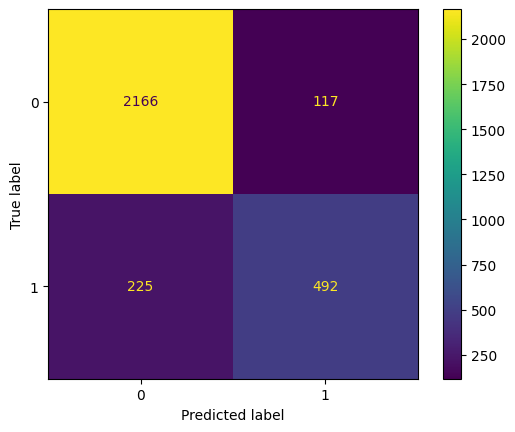

In [214]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()



In [215]:
# Build KNN model pipeline with 15 neighbors
knn_15_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

# Train KNN model with 15 neighbors
knn_15_pipeline.fit(X_train, y_train)

# Predict and evaluate KNN model with 15 neighbors
pred_15 = knn_15_pipeline.predict(X_test)
print(f"KNN (15 neighbors) Accuracy: {accuracy_score(y_test, pred_15)}")
print(f"KNN (15 neighbors) F1 Score: {f1_score(y_test, pred_15)}")
print(f"KNN (15 neighbors) Precision: {precision_score(y_test, pred_15)}")
print(f"KNN (15 neighbors) Recall: {recall_score(y_test, pred_15)}")

# Build KNN model pipeline with 30 neighbors
knn_30_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=30))
])

# Train KNN model with 30 neighbors
knn_30_pipeline.fit(X_train, y_train)

# Predict and evaluate KNN model with 30 neighbors
pred_30 = knn_30_pipeline.predict(X_test)
print(f"KNN (30 neighbors) Accuracy: {accuracy_score(y_test, pred_30)}")
print(f"KNN (30 neighbors) F1 Score: {f1_score(y_test, pred_30)}")
print(f"KNN (30 neighbors) Precision: {precision_score(y_test, pred_30)}")
print(f"KNN (30 neighbors) Recall: {recall_score(y_test, pred_30)}")




KNN (15 neighbors) Accuracy: 0.809
KNN (15 neighbors) F1 Score: 0.5244813278008299
KNN (15 neighbors) Precision: 0.6475409836065574
KNN (15 neighbors) Recall: 0.4407252440725244
KNN (30 neighbors) Accuracy: 0.7983333333333333
KNN (30 neighbors) F1 Score: 0.4051130776794494
KNN (30 neighbors) Precision: 0.6866666666666666
KNN (30 neighbors) Recall: 0.28730822873082285


In [216]:
# Build Logistic Regression model pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train Logistic Regression model
logreg_pipeline.fit(X_train, y_train)

# Predict and evaluate Logistic Regression model
logreg_pred = logreg_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, logreg_pred)}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, logreg_pred)}")
print(f"Logistic Regression Precision: {precision_score(y_test, logreg_pred)}")
print(f"Logistic Regression Recall: {recall_score(y_test, logreg_pred)}")




Logistic Regression Accuracy: 0.8763333333333333
Logistic Regression F1 Score: 0.7130703789636504
Logistic Regression Precision: 0.8003472222222222
Logistic Regression Recall: 0.6429567642956764


In [217]:
# Create a pipeline with a preprocessor and KNN model
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Use GridSearchCV to find the best hyperparameter combination
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

# Output the best hyperparameter combination
print("Best hyperparameters for KNN:", grid_search.best_params_)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best hyperparameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'}


In [218]:
# Build the final KNN model using the best hyperparameters
final_classifier = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
    metric=grid_search.best_params_['classifier__metric'],
    weights=grid_search.best_params_['classifier__weights']
)

# Build the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_classifier)
])

# Train the final model
final_pipeline.fit(X_train, y_train)

# Predict on the test set
pred = final_pipeline.predict(X_test)
probs = final_pipeline.predict_proba(X_test)

# Evaluate model performance
test_accuracy = accuracy_score(y_test, pred)
test_f1 = f1_score(y_test, pred)
test_precision = precision_score(y_test, pred)
test_recall = recall_score(y_test, pred)

print(f"Final Model Test Accuracy: {test_accuracy}")
print(f"Final Model Test F1 Score: {test_f1}")
print(f"Final Model Test Precision: {test_precision}")
print(f"Final Model Test Recall: {test_recall}")



Final Model Test Accuracy: 0.8436666666666667
Final Model Test F1 Score: 0.6628324946081955
Final Model Test Precision: 0.6839762611275965
Final Model Test Recall: 0.6429567642956764


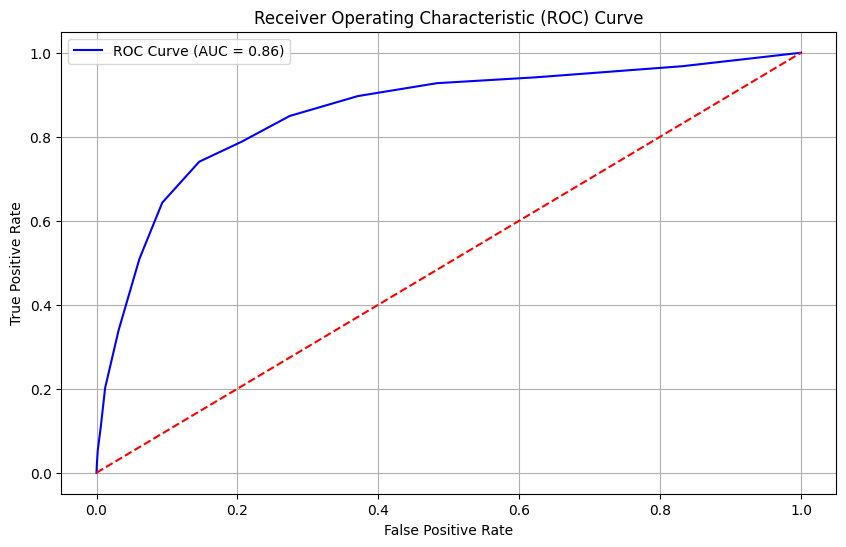

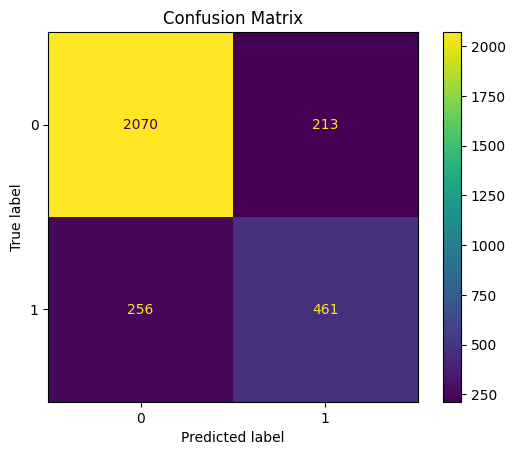

In [219]:
# Calculate ROC curve and AUC score
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()



In [220]:
# Define the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Create a pipeline with a preprocessor and Logistic Regression model
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

# Define the hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['saga']  # saga solver supports l1, l2, and elasticnet
}

# Use GridSearchCV to find the best hyperparameter combination
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

# Output the best hyperparameter combination
print("Best hyperparameters for Logistic Regression:", grid_search.best_params_)



Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimat

Best hyperparameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


In [221]:
# Build the final Logistic Regression model using the best hyperparameters
final_classifier = LogisticRegression(
    C=grid_search.best_params_['classifier__C'],
    penalty=grid_search.best_params_['classifier__penalty'],
    solver=grid_search.best_params_['classifier__solver'],
    max_iter=1000
)

# Build the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_classifier)
])

# Train the final model
final_pipeline.fit(X_train, y_train)

# Predict on the test set
pred = final_pipeline.predict(X_test)
probs = final_pipeline.predict_proba(X_test)

# Evaluate model performance
test_accuracy = accuracy_score(y_test, pred)
test_f1 = f1_score(y_test, pred)
test_precision = precision_score(y_test, pred)
test_recall = recall_score(y_test, pred)

print(f"Final Model Test Accuracy: {test_accuracy}")
print(f"Final Model Test F1 Score: {test_f1}")
print(f"Final Model Test Precision: {test_precision}")
print(f"Final Model Test Recall: {test_recall}")


Final Model Test Accuracy: 0.887
Final Model Test F1 Score: 0.7562904385334291
Final Model Test Precision: 0.7804154302670623
Final Model Test Recall: 0.7336122733612274


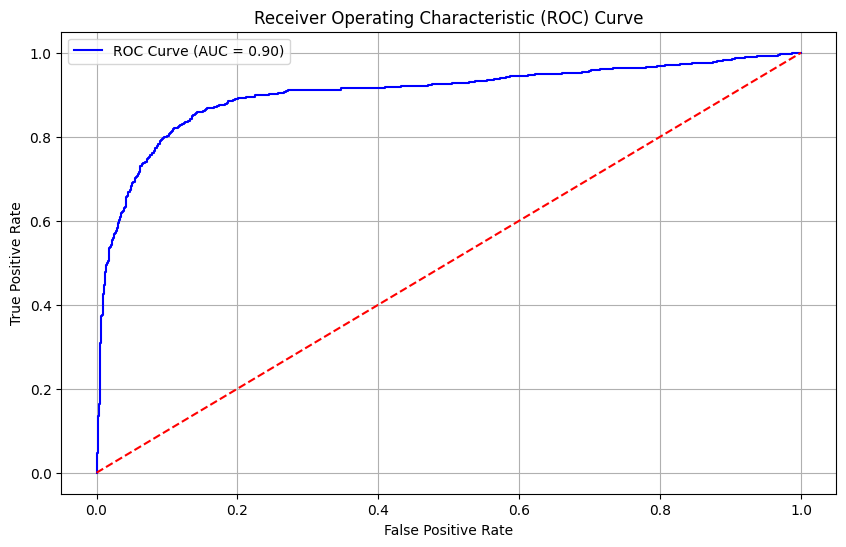

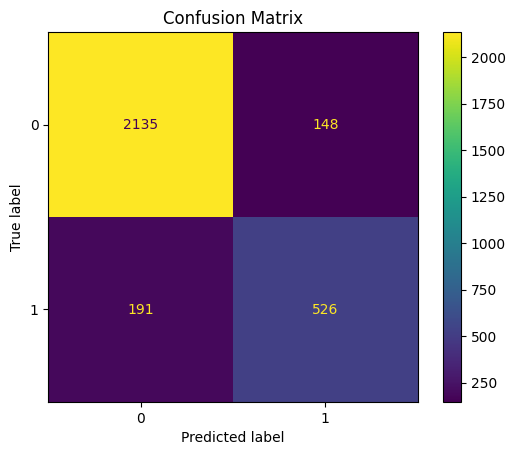

In [222]:
# Calculate ROC curve and AUC score
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()

